To work with this postprocessing library one needs the following libraries:
* numpy
* matplotlib
* scipy
* silx
* h5py
* raysect
* cherab

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hdg_postprocess.formats import load_from_file

* put your meshes to folder data/meshes
* if you do not have them, ask the owner of the repository

we start directly with meshes for parallelized version


! Warning, the library is not yet adapted for serial version (to be done soon)

# Define location and number of partitions

In [2]:
# name of the meshes without the end with mesh number and the total number of meshes
meshbase = 'West_NoHole_Nel81446_P'
meshpath = 'data/meshes/'
# number of partitions in the mesh
n_partitions = 8


# load mesh

In [3]:

mesh = load_from_file.load_HDG_mesh_from_file(meshpath,meshbase,n_partitions)

# Plot overviews

## First, here is the routine to plot raw meshes

No reference element, the mesh is plotted assuming straight edges
No reference element, the mesh is plotted assuming straight edges
No reference element, the mesh is plotted assuming straight edges
No reference element, the mesh is plotted assuming straight edges
No reference element, the mesh is plotted assuming straight edges
No reference element, the mesh is plotted assuming straight edges
No reference element, the mesh is plotted assuming straight edges
No reference element, the mesh is plotted assuming straight edges


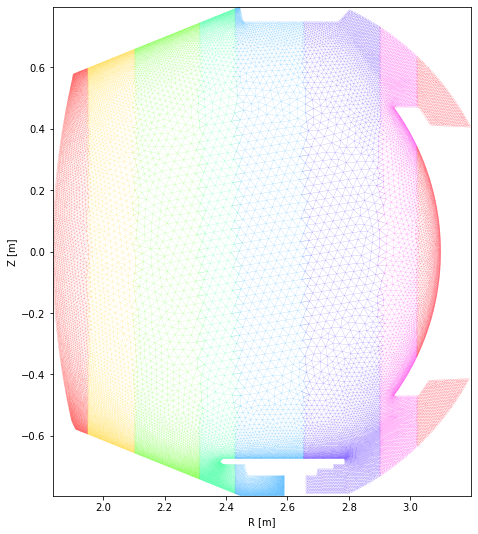

In [4]:
# here you can see that poloidal cross-section of WEST tokamak is cuted into 8 partitons
fig,ax = plt.subplots(figsize=(9,9))
ax = mesh.plot_raw_meshes(ax=ax)
# if needed, the vertices of raw meshes are stored in mesh.raw_vertices 
# and connectivities are stored in mesh.raw_connectivity

## now we can easily recombine our mesh into single one

In [5]:
mesh.recombine_full_mesh()

No reference element, the mesh is plotted assuming straight edges


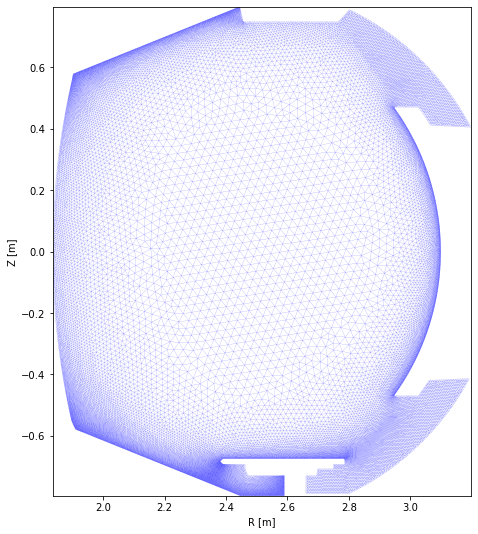

In [6]:
# Now our mesh is stored in mesh.vertices_glob and mesh.connectivity_glob
fig,ax = plt.subplots(figsize=(9,9))
# one can use this routine even without recombine_full_mesh(), plot_full_mesh will call it
ax = mesh.plot_full_mesh(ax=ax)


### Now let's zoom in to one (curved) element

No reference element, the mesh is plotted assuming straight edges


(-0.471, -0.467)

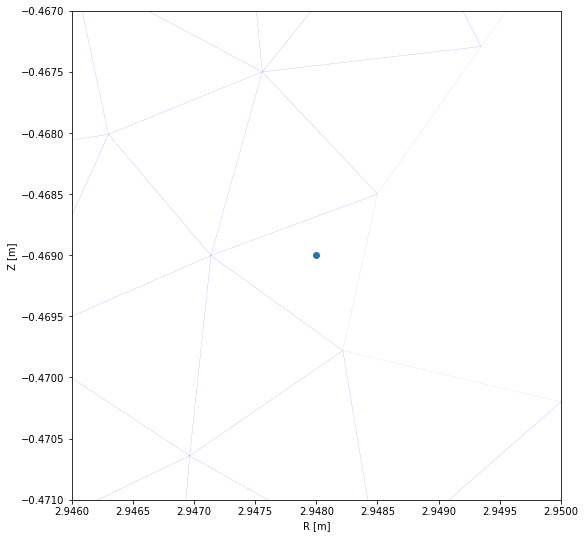

In [7]:
fig,ax = plt.subplots(figsize=(9,9))
ax = mesh.plot_full_mesh(ax=ax)
ax.scatter(2.948,-0.469)
ax.set_xlim(2.946,2.950)
ax.set_ylim(-0.471,-0.467)


### and if you want to know the number of an element where the blu point lies, one can easily make it

In [8]:
# the definition of element number function will take some time, but then it's fast
mesh.make_element_number_funtion()

In [9]:
element_number = int(mesh.element_number(2.948,-0.469))

In [10]:
adjacent_elements =mesh.find_adjacent_elements(element_number)

## now let's plot this and adjacent element's nodes

No reference element, the mesh is plotted assuming straight edges


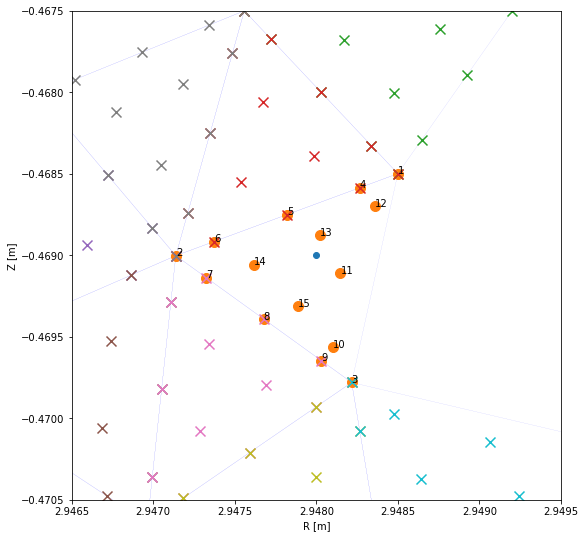

In [11]:
fig,ax = plt.subplots(figsize=(9,9))
ax = mesh.plot_full_mesh(ax=ax)
ax.scatter(2.948,-0.469)
ax.set_xlim(2.9465,2.9495)
ax.set_ylim(-0.4705,-0.4675)

# nodes of chosen element
nodes_chosen = mesh.vertices_glob[mesh.connectivity_glob[element_number]]
plt.scatter(nodes_chosen[:,0],nodes_chosen[:,1],marker='o',s=100)
for i,node in enumerate(nodes_chosen):
    plt.text(node[0],node[1],i+1)

#nodes adjacent
nodes_adjacent = mesh.vertices_glob[mesh.connectivity_glob[adjacent_elements,:]]
for nodes in nodes_adjacent:
    plt.scatter(nodes[:,0],nodes[:,1],marker='x', s = 100)



### here one can see that the elements in fact may be curved and there are more than 3 nodes in each element


### also one physical point can be shared by multiple elements and in fact the solutions on the same node but in different elements can be different

### also global problem is posed on skeleton values which are there only on faces of elements
### solutions there may be also different from elemental one

### here is the sketch

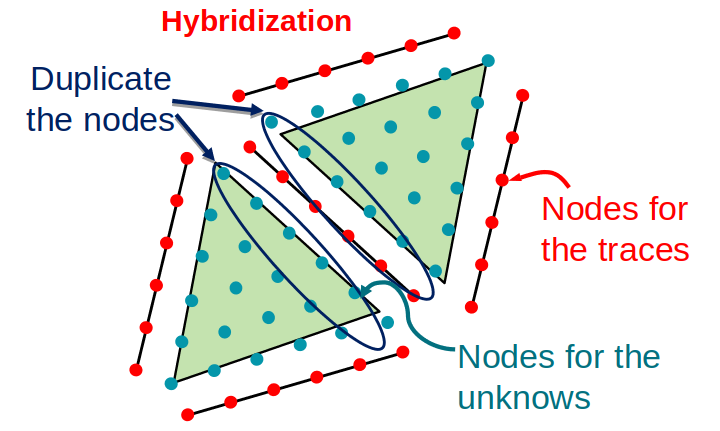

In [12]:
from IPython.display import Image
Image("data/pics/sketch_of_mesh.png")

## Creating connectivity for plotting

### To better visualize the solutions I hardcoded the triangulation of each element of the mesh to use then trcontourf

In [13]:
# this part is there in hdg_mesh class as well, but not as a field of class
triangle_indexes = np.array([[1,4,12],
                        [4,5,13],
                        [5,6,14],
                        [6,2,7],
                        [7,8,14],
                        [8,9,15],
                        [9,3,10],
                        [10,11,15],
                        [11,12,13],
                        [12,4,13],
                        [14,6,7],
                        [13,5,14],
                        [13,14,8],
                        [13,8,15],
                        [15,9,10],
                        [11,13,15]])

triangle_indexes -=1

No reference element, the mesh is plotted assuming straight edges


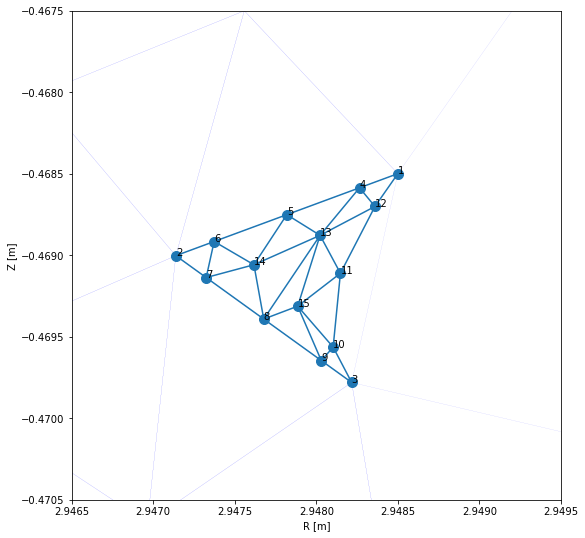

In [14]:
fig,ax = plt.subplots(figsize=(9,9))
ax = mesh.plot_full_mesh(ax=ax)

ax.set_xlim(2.9465,2.9495)
ax.set_ylim(-0.4705,-0.4675)

# nodes of chosen element
nodes_chosen = mesh.vertices_glob[mesh.connectivity_glob[element_number]]
plt.scatter(nodes_chosen[:,0],nodes_chosen[:,1],marker='o',s=100)
for i,node in enumerate(nodes_chosen):
    plt.text(node[0],node[1],i+1)

# extra triangulation
plt.triplot(nodes_chosen[:,0],nodes_chosen[:,1],triangle_indexes)


### to make this extended connectivity matrix

In [15]:
mesh.create_connectivity_big()

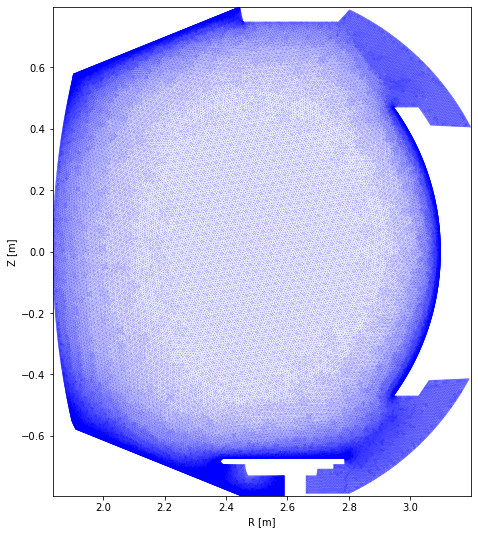

In [16]:
# and one have to pass it to plot routine
fig,ax = plt.subplots(figsize=(9,9))
ax = mesh.plot_full_mesh(ax=ax, connectivity=mesh.connectivity_big)

# Gauss points

## In fact, HDG solves weak problem, thus, integrating over the volume and surface of each element
## Integration is done using Gauss points and Shape functions, which are defined to project values from the nodes of the mesh to the gauss points

## For this we need reference element (in later version of HDG it will be saved in solution)

In [17]:
import scipy
ref_elem = scipy.io.loadmat('data/reference_elements//reference_triangle_P4.mat')

In [18]:
ref_dic = {}
ref_dic['IPcoordinates'] = ref_elem['referenceelement'][0,0][0]  # gauss 2D points coordinates
ref_dic['IPweights'] = ref_elem['referenceelement'][0,0][1][:,0]  # gauss points 2D integration weights
ref_dic['N'] = ref_elem['referenceelement'][0,0][2]  # Shape functions 2D from nodal elements to Gauss points
ref_dic['Nxi'] = ref_elem['referenceelement'][0,0][3]  # Derivative by xi shape functions 2D from nodal elements to Gauss points
ref_dic['Neta'] = ref_elem['referenceelement'][0,0][4]  # Derivative by eta shape functions 2D from nodal elements to Gauss points
ref_dic['IPcoordinates1d'] = ref_elem['referenceelement'][0,0][5]  # gauss 1D points coordinates
ref_dic['IPweights1d'] = ref_elem['referenceelement'][0,0][6]  # gauss points 1D integration weights
ref_dic['N1d'] = ref_elem['referenceelement'][0,0][7]  # Shape functions 1D from nodal elements to Gauss points
ref_dic['N1dxi'] = ref_elem['referenceelement'][0,0][8]  # Derivative by xi shape functions 1D from nodal elements to Gauss points
ref_dic['faceNodes'] = ref_elem['referenceelement'][0,0][9] -1 # connectivity for face nodes
ref_dic['innerNodes'] = ref_elem['referenceelement'][0,0][10] -1 # points that are incide
ref_dic['faceNodes1d'] = ref_elem['referenceelement'][0,0][11] -1 # connectivity for face nodes in 1D
ref_dic['NodesCoord'] = ref_elem['referenceelement'][0,0][12] # coordinates of nodes of an element 
ref_dic['NodesCoord1d'] = ref_elem['referenceelement'][0,0][13]  # coordinates of nodes of in 1D
ref_dic['degree'] = ref_elem['referenceelement'][0,0][14]  # polynomial degree of an element
ref_dic['elemType'] = ref_elem['referenceelement'][0,0][15] # type of element 1 for triangle 0 for quadrangle

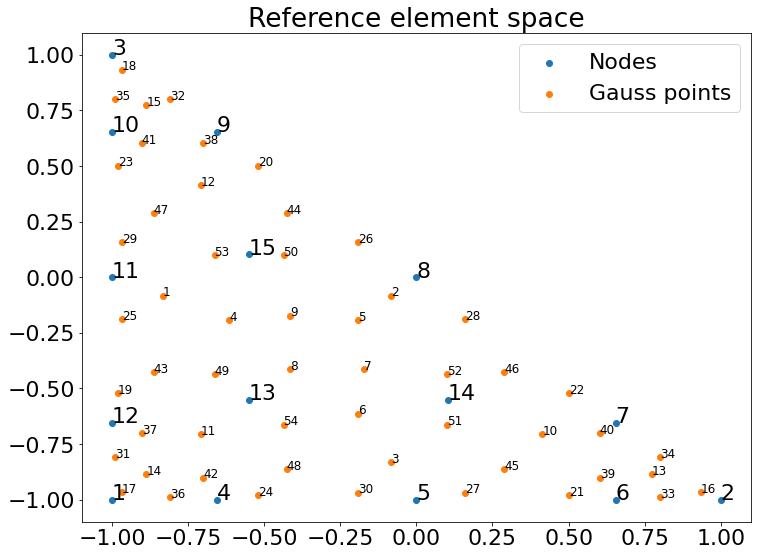

In [19]:
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,9))
plt.scatter(*ref_dic['NodesCoord'].T, label = 'Nodes')
for i, node in enumerate(ref_dic['NodesCoord']):
    plt.text(node[0],node[1],i+1)
plt.title('Reference element space')

plt.scatter(*ref_dic['IPcoordinates'].T, label = 'Gauss points')
for i, node in enumerate(ref_dic['IPcoordinates']):
    plt.text(node[0],node[1],i+1,fontsize=12)
plt.legend()

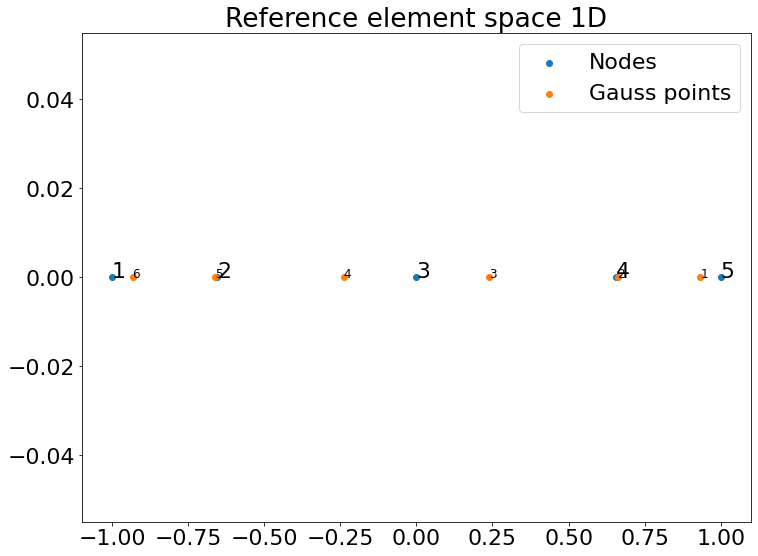

In [20]:
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(12,9))
plt.scatter(ref_dic['NodesCoord1d'].T,np.zeros_like(ref_dic['NodesCoord1d'].T), label = 'Nodes')
for i, node in enumerate(ref_dic['NodesCoord1d']):
    plt.text(node[0],0,i+1)
plt.title('Reference element space 1D')

plt.scatter(ref_dic['IPcoordinates1d'].T,np.zeros_like(ref_dic['IPcoordinates1d'].T), label = 'Gauss points')
for i, node in enumerate(ref_dic['IPcoordinates1d']):
    plt.text(node[0],0,i+1,fontsize=12)
plt.legend()

# here we see that the order of gauss points is inversed

## providing reference element to the mesh we can now calculate volumes of the elements of the mesh


In [21]:
mesh.reference_element = ref_dic
mesh.calculate_gauss_volumes()

In [22]:
mesh.volumes_gauss.sum()
# total volume of plasma

26.74786456723748

In [23]:
mesh.volumes_gauss.shape

(81446, 54)

Full mesh is plotted includin curved edges


<AxesSubplot:xlabel='R [m]', ylabel='Z [m]'>

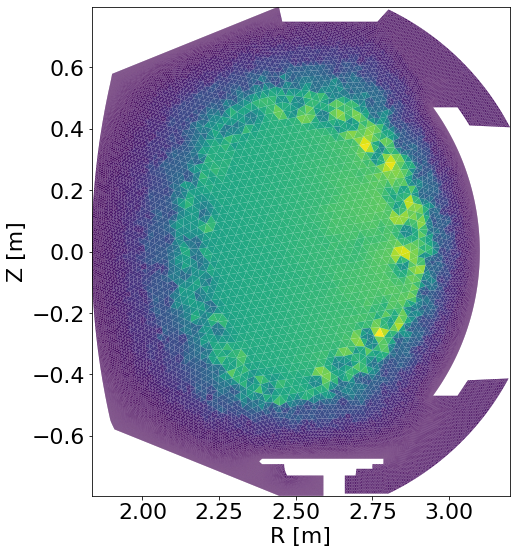

In [24]:
fig,ax = plt.subplots(figsize=(9,9))
# in volumes_gauss the volumes corresponding to each gauss points are stored
mesh.plot_full_mesh(ax=ax,data=mesh.volumes_gauss.sum(axis=1))


# For the other features of HDG_mesh class we need some info from solution, so watch in HDG_solution notebook